In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# Thông báo phiên bản để quản lý (tốt cho Paper)
print(f"Pandas version: {pd.__version__}")

Pandas version: 2.3.1


In [2]:
def preprocess_nsl_kdd(train_path, test_path):
    # 1. Định nghĩa danh sách cột chuẩn (43 cột gốc)
    columns = [
        "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
        "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
        "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
        "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
        "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
        "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
        "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty_level"
    ]

    # 2. Tải dữ liệu
    # Lưu ý: Đảm bảo file .txt nằm đúng thư mục nsl-kdd/
    train_df = pd.read_csv(train_path, names=columns, header=None)
    test_df = pd.read_csv(test_path, names=columns, header=None)

    # Loại bỏ cột độ khó (không dùng để train)
    train_df.drop('difficulty_level', axis=1, inplace=True)
    test_df.drop('difficulty_level', axis=1, inplace=True)

    # 3. Gán nhãn nhị phân: 0 (Normal), 1 (Attack)
    train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

    # 4. One-Hot Encoding cho các cột phân loại (Lý do làm tăng cột lên 123)
    
    categorical_cols = ['protocol_type', 'service', 'flag']
    
    # Gộp lại để encode đảm bảo số lượng cột ở Train và Test khớp nhau
    combined = pd.concat([train_df, test_df], axis=0)
    combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

    train_proc = combined_encoded.iloc[:len(train_df)].copy()
    test_proc = combined_encoded.iloc[len(train_df):].copy()

    # 5. Chuẩn hóa Min-Max về khoảng [0, 1] cho dữ liệu số
    features = [c for c in train_proc.columns if c != 'label']
    scaler = MinMaxScaler()
    train_proc[features] = scaler.fit_transform(train_proc[features])
    test_proc[features] = scaler.transform(test_proc[features])

    return train_proc, test_proc

In [3]:
# Gọi hàm xử lý
# Thay đổi đường dẫn nếu cần thiết
train_clean, test_clean = preprocess_nsl_kdd('nsl-kdd/KDDTrain+.txt', 'nsl-kdd/KDDTest+.txt')

# Lưu file kết quả
train_clean.to_csv('NSL_KDD_Train_Cleaned.csv', index=False)
test_clean.to_csv('NSL_KDD_Test_Cleaned.csv', index=False)

print("--- THÔNG TIN SAU XỬ LÝ ---")
print(f"Kích thước tập Train: {train_clean.shape}")
print(f"Kích thước tập Test: {test_clean.shape}")
print(f"Số lượng đặc trưng (Features): {train_clean.shape[1] - 1}")

# Xem thử 5 dòng đầu tiên
train_clean.head()

--- THÔNG TIN SAU XỬ LÝ ---
Kích thước tập Train: (125973, 123)
Kích thước tập Test: (22544, 123)
Số lượng đặc trưng (Features): 122


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


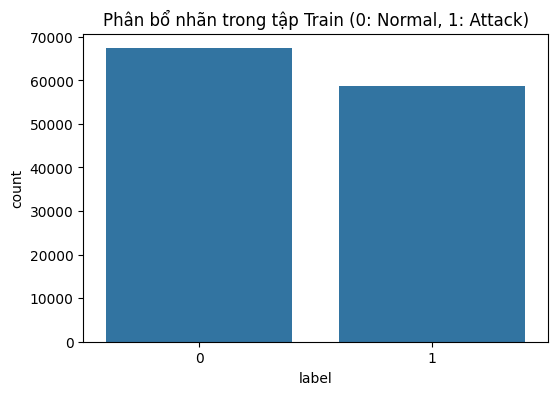

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_clean)
plt.title('Phân bổ nhãn trong tập Train (0: Normal, 1: Attack)')
plt.show()